In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import sys
# sys.path.append("/glade/u/home/jhayron/WeatherRegimes/Scripts/")
# import cluster_analysis, narm_analysis, som_analysis

In [2]:
## The goal of this code is to get DETRENDED daily anomalies of the input variables ALONE
# Z500
# SST - alone
# ST - alone
# SM - alone
# OLR (olr is really top thermal longwave radiation, less negative = positive anomalies = more convection)
# U10


In [3]:
def get_trend(dataset,variable,unit):
    lat = dataset.lat.values
    lon = dataset.lon.values

    array_coefs = np.zeros([len(lat),len(lon)])
    for lati in range(len(lat)):
        # print(lati)
        for loni in range(len(lon)):
        # for loni in [0]:
            series = dataset.sel(lat=lat[lati],lon=lon[loni])[variable]
            X = [i for i in range(0, len(series))]
            X = np.reshape(X, (len(X), 1))
            y = series.values
            try:
                model = LinearRegression()
                model.fit(X, y)
                array_coefs[lati,loni] = model.coef_[0]
            except:
                array_coefs[lati,loni] = 0
    trend = xr.Dataset({
                 f'{variable}_trend': (['lat','lon'], array_coefs),
                },
                 coords =
                {
                 'lat' : (['lat'], lat),
                 'lon' : (['lon'], lon)
                },
                attrs = 
                {'File Author' : 'Jhayron S. Pérez-Carrasquilla','units':f'({unit})/day'})
    return trend

# Detrend

In [4]:
names_variables = ['z500','olr', 'sm', 'sst', 'st', 'u10']
units = ['m2/s2','J/m2','m3/m3','K','K','m/s']

In [6]:
for iname in range(len(names_variables)):
    print(names_variables[iname])
    dataset_era = xr.open_dataset(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/netcdf_final/{names_variables[iname]}.nc')
    dataset_era = dataset_era.load()
    #daily climatology
    dataset_era = dataset_era.isel(time = pd.to_datetime(dataset_era.time).year<=2010)
    
    trend = get_trend(dataset_era,names_variables[iname],units[iname])
    trend.to_netcdf(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/trends/{names_variables[iname]}_trend.nc')
    

z500
olr
sm
sst
st
u10


In [5]:
def detrend(dataset,variable,trend):
    lat = dataset.lat.values
    lon = dataset.lon.values
    X = np.array([i for i in range(0, len(dataset[variable]))])
    X_3d = np.repeat(X[:,None], len(lat), axis=1)
    X_3d = np.repeat(X_3d[:,:,None],len(lon),axis=2)
    rect_lines = X_3d * trend[f'{variable}_trend'].values
    detrended_data = dataset[variable]-rect_lines
    return detrended_data

In [20]:
for iname in range(len(names_variables)):
    print(names_variables[iname])
    dataset_era = xr.open_dataset(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/netcdf_final/{names_variables[iname]}.nc')
    dataset_era = dataset_era.load()
    
    trend = xr.open_dataset(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/trends/{names_variables[iname]}_trend.nc')
    detrended_da = detrend(dataset_era,names_variables[iname],trend)
    dataset_era[names_variables[iname]] = detrended_da
    dataset_era.attrs = {'File Author' : 'Jhayron S. Pérez-Carrasquilla','units':units[iname],'Detrended':'Trend computed from 1959-2010 was removed'}
    dataset_era.to_netcdf(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/netcdf_final/{names_variables[iname]}_detrended.nc')
    

z500
olr
sm
sst
st
u10


# Initially do the anom process for each variable individually

In [6]:
for iname in range(5,len(names_variables)):
    print(names_variables[iname])
    dataset_era = xr.open_dataset(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/netcdf_final/{names_variables[iname]}_detrended.nc')
    #daily climatology
    dataset_era = dataset_era.isel(time = pd.to_datetime(dataset_era.time).year<=2010)
    dataset_era = dataset_era.isel(time = ~((pd.to_datetime(dataset_era.time).day == 29)&((pd.to_datetime(dataset_era.time).month == 2))))
    # dataset_era
    doy = pd.to_datetime(dataset_era.time).day_of_year
    climatology = []
    for i in range(1,366):
        climatology.append(dataset_era.isel(time = doy == i)[names_variables[iname]].mean('time'))
    climatology = xr.Dataset({
                 f'{names_variables[iname]}_climatology': (['day_of_year','lat','lon'], np.array(climatology)),
                },
                 coords =
                {'day_of_year': (['day_of_year'], np.arange(1,366)),
                 'lat' : (['lat'], dataset_era.lat.values),
                 'lon' : (['lon'], dataset_era.lon.values)
                },
                attrs = 
                {'File Author' : 'Jhayron S. Pérez-Carrasquilla','units':units[iname]})
    climatology.to_netcdf(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/climatologies/{names_variables[iname]}_climatology_1959_2010_detrended.nc')
    smooth_climatology = xr.concat([climatology[f'{names_variables[iname]}_climatology'], climatology[f'{names_variables[iname]}_climatology'],climatology[f'{names_variables[iname]}_climatology']], dim='day_of_year')
    smooth_climatology = smooth_climatology.rolling(day_of_year=31, min_periods=1, center=True).mean(skipna=True).rolling(
                                      day_of_year=31, min_periods=1, center=True).mean(skipna=True)
    smooth_climatology = smooth_climatology.isel(day_of_year=slice(365,365 * 2))
    smooth_climatology = smooth_climatology.transpose('day_of_year','lat','lon')
    
    ### compute anomalies
    
    dataset_era = xr.open_dataset(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/netcdf_final/{names_variables[iname]}_detrended.nc')
    anomalies = copy.deepcopy(dataset_era)
    
    for day in range(1,367):
        # print(day) 
        if day == 366:
            anomalies[names_variables[iname]][{'time':(pd.to_datetime(dataset_era.time).day_of_year == day)}] = \
                (dataset_era[names_variables[iname]].isel(time = (pd.to_datetime(dataset_era.time).day_of_year == day)) \
                - smooth_climatology.sel(day_of_year = day-1))
        else:
            anomalies[names_variables[iname]][{'time':(pd.to_datetime(dataset_era.time).day_of_year == day)}] = \
                (dataset_era[names_variables[iname]].isel(time = (pd.to_datetime(dataset_era.time).day_of_year == day)) \
                - smooth_climatology.sel(day_of_year = day))
    anomalies = anomalies.rename({names_variables[iname]:f'{names_variables[iname]}_anomalies'})
    anomalies.to_netcdf(f'/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/{names_variables[iname]}_anomalies_v1959_2010_detrended.nc')
    
    

u10


# Create combined datasets

## SST (ocean) + ST (land)

In [5]:
path_anomalies = '/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/'

In [6]:
sst_anoms = xr.open_dataset(f'{path_anomalies}sst_anomalies_v1959_2010_detrended.nc')
st_anoms = xr.open_dataset(f'{path_anomalies}st_anomalies_v1959_2010_detrended.nc')

In [7]:
where_land = np.where(np.isfinite(sst_anoms.isel(time=0).sst_anomalies)==False)
where_ocean = np.where(np.isfinite(sst_anoms.isel(time=0).sst_anomalies)==True)

In [8]:
np.save(f'{path_anomalies}where_land',where_land)
np.save(f'{path_anomalies}where_ocean',where_ocean)

In [9]:
array_sst = copy.deepcopy(sst_anoms.sst_anomalies.values)
array_st = copy.deepcopy(st_anoms.st_anomalies.values)

In [10]:
for i in range(len(array_sst)):
    array_sst[i,where_land[0],where_land[1]] = array_st[i,where_land[0],where_land[1]]

In [11]:
sst_st_anoms = copy.deepcopy(sst_anoms)
sst_st_anoms = sst_st_anoms.assign(sst_anomalies = (sst_st_anoms.sst_anomalies.dims,array_sst))

In [12]:
sst_st_anoms.to_netcdf(f'{path_anomalies}sst_st_anomalies_v1959_2010_detrended.nc')

## SST (ocean) + SM (land)

In [6]:
path_anomalies = '/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/'

In [9]:
sst_anoms = xr.open_dataset(f'{path_anomalies}sst_anomalies_v1959_2010_detrended.nc')
sm_anoms = xr.open_dataset(f'{path_anomalies}sm_anomalies_v1959_2010_detrended.nc')

In [10]:
array_sst = copy.deepcopy(sst_anoms.sst_anomalies.values)
array_sm = copy.deepcopy(sm_anoms.sm_anomalies.values)

In [12]:
where_land = np.load(f'{path_anomalies}where_land.npy')
where_ocean = np.load(f'{path_anomalies}where_ocean.npy')

In [13]:
for i in range(len(array_sst)):
    array_sst[i,where_land[0],where_land[1]] = array_sm[i,where_land[0],where_land[1]]

In [14]:
sst_sm_anoms = copy.deepcopy(sm_anoms)
sst_sm_anoms = sst_sm_anoms.assign(sm_anomalies = (sst_sm_anoms.sm_anomalies.dims,array_sst))

In [15]:
sst_sm_anoms.to_netcdf(f'{path_anomalies}sst_sm_anomalies_v1959_2010_detrended.nc')

# Test random

In [2]:
path_anomalies = '/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/'

In [5]:
sst_anoms = xr.open_dataset(f'{path_anomalies}sst_anomalies_v1959_2010.nc')
sst_anoms_detrended = xr.open_dataset(f'{path_anomalies}sst_anomalies_v1959_2010_detrended.nc')


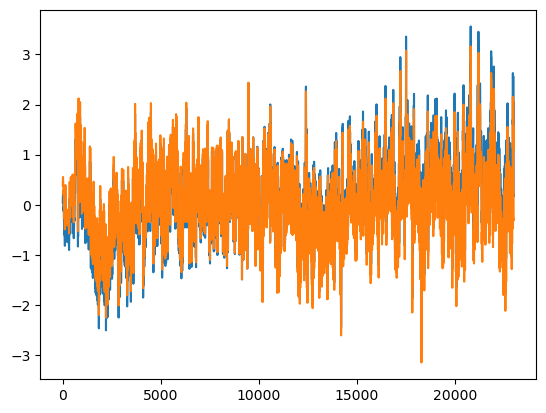

In [8]:
plt.plot(sst_anoms.sst_anomalies[:,30,60])
plt.plot(sst_anoms_detrended.sst_anomalies[:,30,60])

In [10]:
# :)